## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [2]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import censoring

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [4]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [6]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] <= 548) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined')
        ].copy()

### Reshape data to move players/difficulty to columns

In [7]:
alias_list = [ censoring.name_alias[i] for i in [*censoring.name_alias]]
# create dummy dataset for predictors
playerDummies = pd.get_dummies(df2['Name'])
difficultyDummies = pd.get_dummies(df2['Difficulty'])
# create dummy dataset for interactions
template = np.zeros((len(playerDummies.index), 8*2))
c = 0
interaction_list = []
for i in playerDummies.columns: 
    for j in difficultyDummies.columns:
        new_vector = playerDummies[i].values * difficultyDummies[j].values
        template[:, c] = new_vector
        interaction_list.append(i + '_' + j)
        c += 1
        
interactionDummies = pd.DataFrame(template, columns=interaction_list)

## Model
The 'players' are treated as one-hot encoded columns. This allows me to make predicions by using pm.set_data(). But is it worth it? 

Should I be adding a 'puzzle' dimension, here? 
Need to double-check which variables I am pooling / not-pooling. From a conceptual standpoint, each player should be independent, but difficulty should not be independent?

In [8]:
with pm.Model(
    coords={
        "obs": df2.index.values, 
        "Player": playerDummies.columns,
        "Difficulty": difficultyDummies.columns,
        "PlayerDifficulty": interactionDummies.columns
    }
) as BB2:
    
    # using pm.data
    y = pm.MutableData("y", df2['Fails'].to_numpy())
    xPlayers = pm.MutableData("xPlayers", playerDummies.to_numpy())
    xDifficulty = pm.MutableData("xDifficulty", difficultyDummies.to_numpy())
    xInteraction = pm.MutableData("xInteraction", interactionDummies.to_numpy())
    
    # Names
    Namesβ = pm.HalfNormal("Namesβ", sigma=1, dims="Player")

    # Difficulty
    Diffβ = pm.HalfNormal("Diffβ", sigma=1, dims="Difficulty")

    # Interaction
    Interβ = pm.HalfNormal("Interβ", sigma=1, dims="PlayerDifficulty")
    
    # Error
    ϵβ = pm.HalfNormal("ϵβ", sigma=1)
    
    # likelihood
    θα = pm.HalfNormal("θα", sigma=1)
    θβ = pm.Deterministic("θβ", pm.math.dot(xPlayers, Namesβ) + pm.math.dot(xDifficulty, Diffβ) + pm.math.dot(xInteraction, Interβ) + ϵβ)

    # response
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=θα, 
        beta=θβ, 
        observed=y
    )

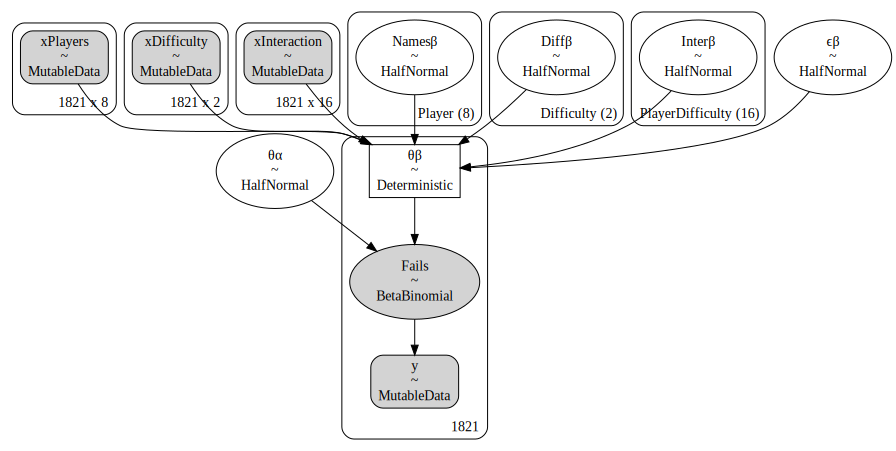

In [9]:
pm.model_to_graphviz(BB2)

In [10]:
with BB2:
    trace2 = pm.sample(
        draws=1000,
        tune=2000,
        # start={
        #     'Namesβ': np.array([1., 1., 1., 1., 1., 1.]), 
        #     'Namesα': np.array([1., 1., 1., 1., 1., 1.]), 
        # }, 
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Namesβ, Diffβ, Interβ, ϵβ, θα]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 318 seconds.


## Display Summary

In [11]:
az.summary(trace2, var_names=["Namesβ", "Diffβ", "Interβ", "ϵβ"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Namesβ[Ca.W],0.828,0.511,0.000,1.711,0.010,0.007,1980.0,1087.0,1.0
Namesβ[Da.M],1.197,0.574,0.099,2.183,0.014,0.010,1454.0,878.0,1.0
Namesβ[Da.S],0.439,0.332,0.000,1.037,0.007,0.005,1974.0,1613.0,1.0
Namesβ[Ja.F],0.824,0.596,0.004,1.862,0.008,0.006,4012.0,1984.0,1.0
Namesβ[Ka.S],0.752,0.455,0.002,1.535,0.009,0.006,2140.0,1278.0,1.0
Namesβ[Ka.W],0.716,0.444,0.002,1.473,0.008,0.006,2540.0,1576.0,1.0
Namesβ[St.S],2.404,0.692,1.028,3.635,0.014,0.010,2466.0,1840.0,1.0
Namesβ[Su.S],1.077,0.655,0.001,2.158,0.012,0.008,2151.0,1095.0,1.0
Diffβ[Easy],2.513,0.596,1.465,3.701,0.013,0.009,1983.0,2256.0,1.0
Diffβ[Hard],1.083,0.570,0.004,2.032,0.013,0.009,1705.0,1462.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

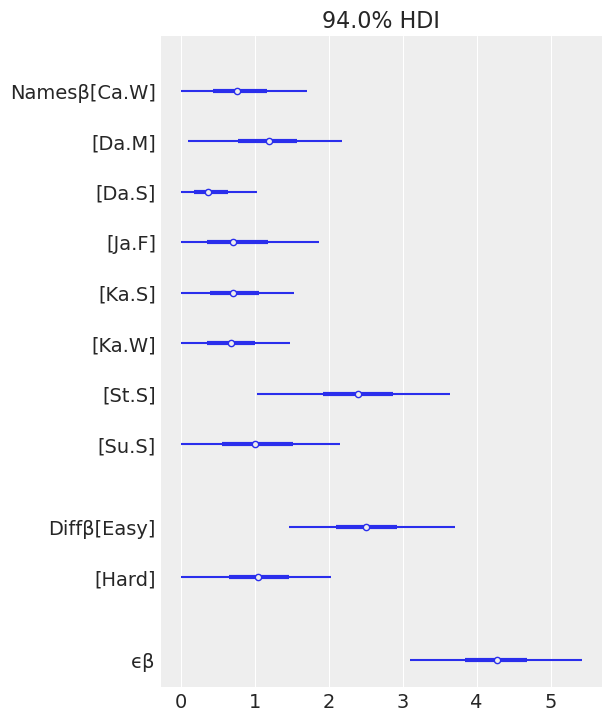

In [12]:
az.plot_forest(trace2, var_names=["Namesβ", "Diffβ", "ϵβ"], combined=True)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

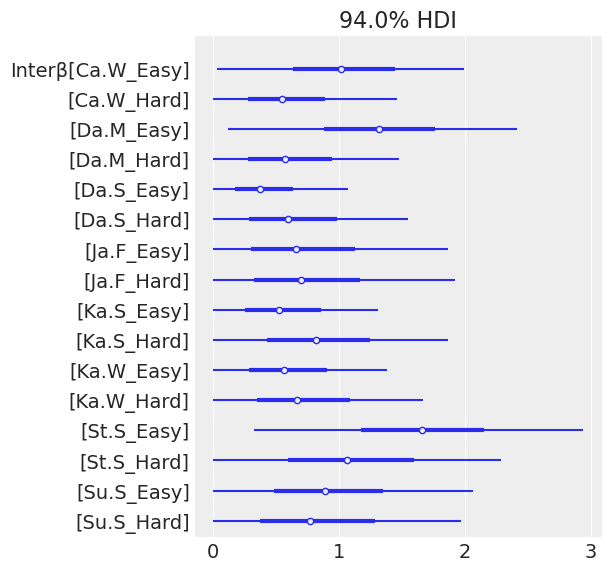

In [13]:
az.plot_forest(trace2, var_names=["Interβ"], combined=True)

## Posterior Predictive

Sampling the posterior predictive to see how the 'fit' compares to actual values

In [14]:
with BB2:
    ppc_data_trace2 = pm.sample_posterior_predictive(trace2, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

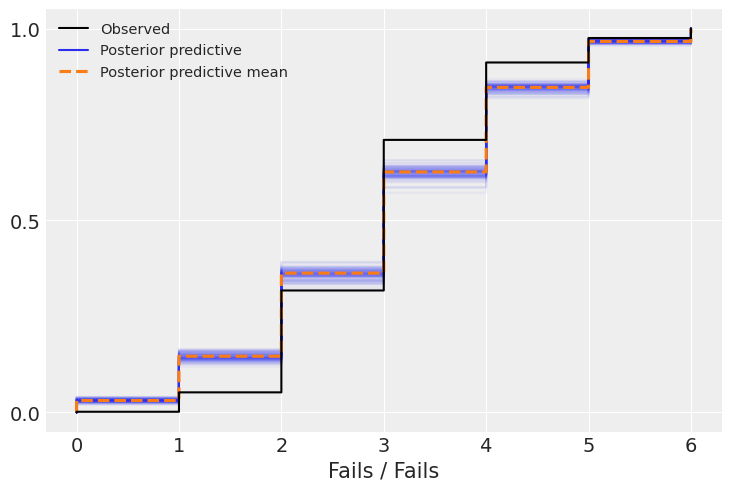

In [15]:
az.plot_ppc(ppc_data_trace2, alpha=0.05, kind="cumulative", num_pp_samples=100)

## Generate Fitted Values

The key here is to use the 'set_data' attribute. Running the model again with the same data causes the model to generate predictions. The previous run generated draws for _parameter_ values. Here we're getting the fitted _response_ values.

In [19]:
with BB2:
    pm.set_data({
        "y" : df2['Fails'].to_numpy(),
        "xPlayers" : playerDummies.to_numpy(),
        "xDifficulty" : difficultyDummies.to_numpy(),
        "xInteraction" : interactionDummies.to_numpy()
    })
    
    y_test = pm.sample_posterior_predictive(trace2)

In [20]:
playerOut = playerDummies.copy()
diffOut = difficultyDummies.copy()
interOut = interactionDummies.copy()

### Players

In [21]:
# Add the fails and the predictions to the player dummies
playerOut['Fails'] = df2['Fails']
playerOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
# get columns to aggregate and melt by
cols=playerOut.columns[:-1].to_list()
# melt
playerOut = playerOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
playerOut = pd.melt(playerOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

### Difficulty

In [22]:
diffOut['Fails'] = df2['Fails']
diffOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
cols=diffOut.columns[:-1].to_list()
diffOut = diffOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
diffOut = pd.melt(diffOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

### Interactions

In [23]:
interOut['Fails'] = df2['Fails']
interOut['Predictions'] = y_test.posterior_predictive['Fails'].mean(('chain', 'draw'))
cols=interOut.columns[:-1].to_list()
interOut = interOut.groupby(cols).agg({'Predictions':'mean'}).reset_index()
interOut = pd.melt(interOut, id_vars=['Fails','Predictions']).drop('value',axis=1)

## Write Output

In [24]:
# write the summary file
az.summary(trace2, var_names=["Namesβ", "Diffβ", "Interβ", "ϵβ"]).to_csv(censoring.model_output, index=False)
# write the fitted values
playerOut.to_csv(censoring.playerOut, index=False)
diffOut.to_csv(censoring.diffOut, index=False)
interOut.to_csv(censoring.interOut, index=False)